In [ ]:
# pip install scikit-image

In [2]:
import pickle
import main
import main_comp

%load_ext autoreload
%autoreload 1
%aimport main
%aimport main_comp

In [3]:
def save_logs(directory, logs):
    for log_name, log in logs.items():
        with open(directory + log_name, 'wb') as f:
            f.write(pickle.dumps(log))

In [4]:
def time_memory_consumption(data, path):
    with open(path, 'a') as f:
        f.write(data)

# Original NN

In [5]:
from models.skip import skip

In [6]:
input_depth = 32
n_channels = 3
skip_n33d = 128
skip_n33u = 128
skip_n11 = 4
num_scales = 5
upsample_mode = 'bilinear'
downsample_mode = 'stride'
pad = 'reflection'
act_fun = 'LeakyReLU'

In [7]:
net = skip(
    input_depth, 
    n_channels,
    num_channels_down=[skip_n33d] * num_scales,
    num_channels_up=[skip_n33u] * num_scales,
    num_channels_skip=[skip_n11] * num_scales,
    upsample_mode=upsample_mode, 
    downsample_mode=downsample_mode,
    need_sigmoid=True, 
    need_bias=True,
    pad=pad, 
    act_fun=act_fun
)
net

Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): Sequential(
        (1): Concat(
          (0): Sequential(
  

In [8]:
from torch.profiler import profile, record_function, ProfilerActivity

In [9]:
device = 'cuda'

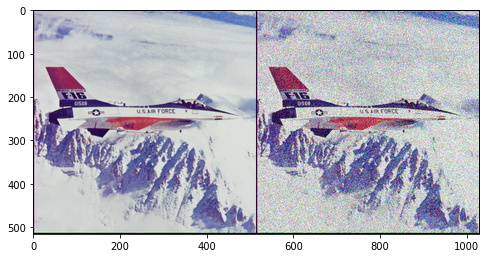

Number of params: 2217831
Starting optimization with ADAM


/home/Skoltech_MSc/TDTN/final_project/denoising_compression/main_comp.py:109: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_noisy = compare_ssim(img_noisy_np.T, out.detach().cpu().numpy()[0].T, multichannel=True)
/home/Skoltech_MSc/TDTN/final_project/denoising_compression/main_comp.py:110: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_gt = compare_ssim(img_np.T, out.detach().cpu().numpy()[0].T, multichannel=True)


Iteration 00000  Loss 0.106911  PSNR_noisy: 9.709775  PSNR_gt: 10.725150  PSNR_gt_sm: 10.725150  SSIM_noisy: 0.089093  SSIM_gt: 0.528832


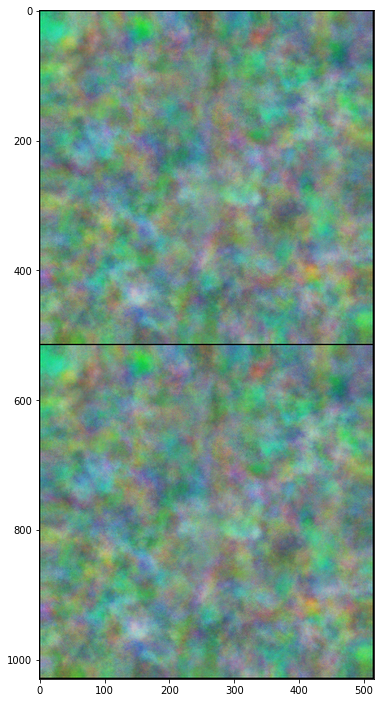

Iteration 00001  Loss 0.090878  PSNR_noisy: 10.415436  PSNR_gt: 11.771470  PSNR_gt_sm: 10.752821  SSIM_noisy: 0.092853  SSIM_gt: 0.614070
Iteration 00002  Loss 0.091349  PSNR_noisy: 10.392961  PSNR_gt: 11.819118  PSNR_gt_sm: 10.792640  SSIM_noisy: 0.094251  SSIM_gt: 0.633331
Iteration 00003  Loss 0.068829  PSNR_noisy: 11.622303  PSNR_gt: 13.885009  PSNR_gt_sm: 10.854067  SSIM_noisy: 0.098356  SSIM_gt: 0.694292
Iteration 00004  Loss 0.069759  PSNR_noisy: 11.564017  PSNR_gt: 13.845202  PSNR_gt_sm: 10.920782  SSIM_noisy: 0.098502  SSIM_gt: 0.713217
Iteration 00005  Loss 0.061122  PSNR_noisy: 12.138030  PSNR_gt: 14.928146  PSNR_gt_sm: 10.993466  SSIM_noisy: 0.099411  SSIM_gt: 0.719577
Iteration 00006  Loss 0.057266  PSNR_noisy: 12.421026  PSNR_gt: 15.435335  PSNR_gt_sm: 11.061216  SSIM_noisy: 0.099638  SSIM_gt: 0.717869
Iteration 00007  Loss 0.056860  PSNR_noisy: 12.451921  PSNR_gt: 15.460957  PSNR_gt_sm: 11.126436  SSIM_noisy: 0.099437  SSIM_gt: 0.718050
Iteration 00008  Loss 0.055922  PS

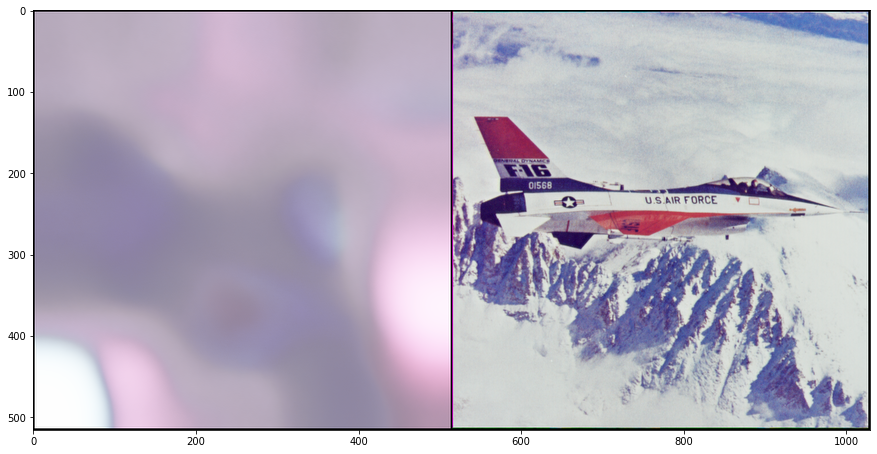

In [10]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
    profile_memory=True, 
    record_shapes=True
) as prof:
    with record_function("model_performance"):
        losses, psnrs_noisy, psnrs_gt, ssims_noisy, ssims_gt = main_comp.main_func(net, True, device=device)
time_memory_consumption(prof.key_averages().table(), './logs/original_net.txt')

In [11]:
save_logs(
    './logs/', 
    {
        'losses': losses, 
        'psnrs_noisy': psnrs_noisy, 
        'psnrs_gt': psnrs_gt, 
        'ssims_noisy': ssims_noisy, 
        'ssims_gt': ssims_gt
    }
)

# Compressed NN

In [12]:
def get_layer_by_name(model, mname):
    '''
    Extract layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list:
        module = module._modules[mname]

    return module


def replace_conv_layer_by_name(model, mname, new_layer):
    '''
    Replace layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list[:-1]:
        module = module._modules[mname]
    module._modules[mname_list[-1]] = new_layer

In [13]:
def calculate_layer_cr(model_stats, lnames_to_compress, cr=2):
    '''
    When we compres whole model with compression ratio `cr`,
    we need to calculate layer compression ratio for each layer
    from `lnames_to_compress`. We apply the same compression rate
    to all layers.
    
    Returns: float
        layer compression ratio
        '''

    flops_to_compress = 0
    for lname in lnames_to_compress:
        flops_to_compress += model_stats.flops[lname][0]
    uncompressed_flops = model_stats.total_flops - flops_to_compress
    layer_cr = flops_to_compress * cr / (flops_to_compress + uncompressed_flops * (1- cr))
    return layer_cr

In [14]:
from copy import deepcopy

In [15]:
# pip install musco-pytorch, flopco-pytorch

In [16]:
from musco.pytorch import CompressorVBMF, CompressorPR, CompressorManual

In [17]:
import flopco
from flopco import FlopCo

In [18]:
def get_compressed_model(model, conv2d_nn_decomposition, model_compression_ratio=2, device='cpu'):
    model.to(device)
    model_stats = FlopCo(model, img_size=(1, 32, 512, 512), device=device)
    lnames = list(model_stats.flops.keys())
    lnames_to_compress = [
        lname for lname, layer in model.named_modules() 
        if str(layer).startswith('Conv2d') and '0' not in lname and '6' not in lname and '9' not in lname
    ]
    print(len(lnames_to_compress))

    layer_cr = calculate_layer_cr(model_stats, lnames_to_compress, cr=model_compression_ratio)

    param_reduction_rates = {lname: layer_cr for lname in lnames_to_compress}

    ### Implement CompressorPR class here

    compressor = CompressorPR(model,
                              model_stats,
                              conv2d_nn_decomposition=conv2d_nn_decomposition,
                              ft_every=len(lnames_to_compress), 
                              param_reduction_rates=param_reduction_rates,
                              nglobal_compress_iters=1)

    ### 
    compressor.lnames = lnames_to_compress
    
    compressor.compression_step()

    return compressor.compressed_model

In [19]:
for lname, layer in net.named_modules():
    if str(layer).startswith('Conv2d') and ('0' in lname or '6' in lname or '9' in lname):
        print(lname, layer)
# These convoluitonal layers can't be compressed

1.0.1.1 Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
9.1 Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))


In [ ]:
compressed_model = get_compressed_model(net, 'tucker2', 8) # Change 'tucker2' parameter here

15
1.1.1.1 tucker2


In [ ]:
compressed_model.to(device)

In [ ]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
    profile_memory=True, 
    record_shapes=True
) as prof:
    with record_function("model_performance"):
        losses_comp, psnrs_noisy_comp, psnrs_gt_comp, ssims_noisy_comp, ssims_gt_comp = main_comp.main_func(compressed_model, True, device=device)
time_memory_consumption(prof.key_averages().table(), './logs/compressed_conv2d_tucker2.txt')

In [ ]:
save_logs(
    './logs/', 
    {
        'losses_comp': losses_comp, 
        'psnrs_noisy_comp': psnrs_noisy_comp, 
        'psnrs_gt_comp': psnrs_gt_comp, 
        'ssims_noisy_comp': ssims_noisy_comp, 
        'ssims_gt_comp': ssims_gt_comp
    }
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses_comp, label='comp')
plt.plot(losses, label='orig')
plt.legend()